In [2]:
import warnings
warnings.filterwarnings('ignore')

![title](img/RAG-Traid.png)

In [3]:
import utils

import os
import openai

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [4]:
openai.api_key = utils.get_openai_api_key()

In [5]:
from trulens_eval import Tru

tru = Tru()
tru.reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


In [6]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files = ["./data/eBook-How-to-Build-a-Career-in-AI_2.pdf"]
).load_data()

In [7]:
from llama_index import Document

document = Document(text = "\n\n".join([doc.text for doc in documents]))

In [8]:
from utils import build_sentence_window_index
from llama_index.llms import OpenAI

llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1)

sentence_index = build_sentence_window_index(
    document,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="sentence_index"
)

In [9]:
from utils import get_sentence_window_query_engine

sentence_window_engine = get_sentence_window_query_engine(sentence_index)

In [10]:
output = sentence_window_engine.query(
    "How do you create your portfolio?"
)
print(output.response)

Creating a portfolio involves building a collection of projects that demonstrate progress over time, starting from simple undertakings and moving on to more complex ones. It is important to communicate the value of your work and explain your thinking to others in order to gain their trust and support. This will help bring colleagues, mentors, and managers onboard and allow them to provide feedback on your reasoning. Additionally, after completing a project, being able to clearly explain what you have accomplished will help convince others to give you opportunities for larger projects.


## Feedback functions

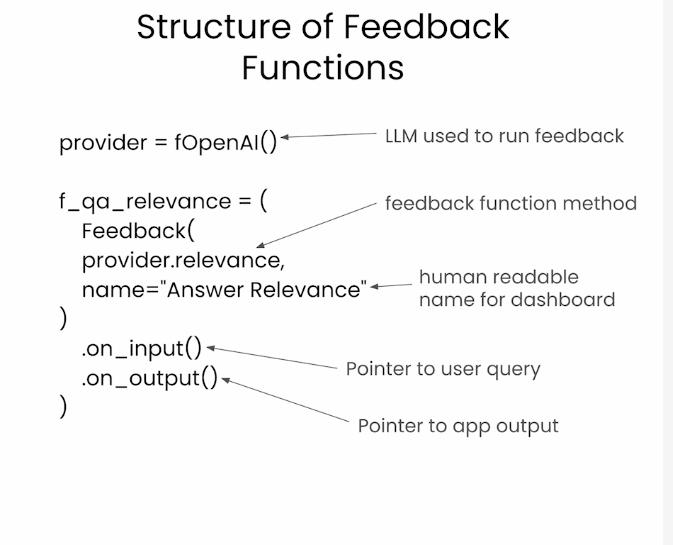

In [11]:
import nest_asyncio

nest_asyncio.apply()

In [12]:
from trulens_eval import OpenAI as fOpenAI

# Will use gpt-3.5-turbo by default

provider = fOpenAI()

#### 1. Answer Relevance

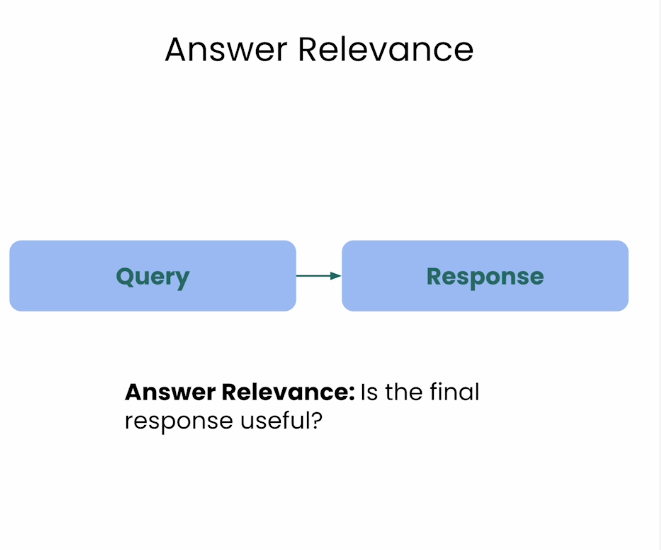

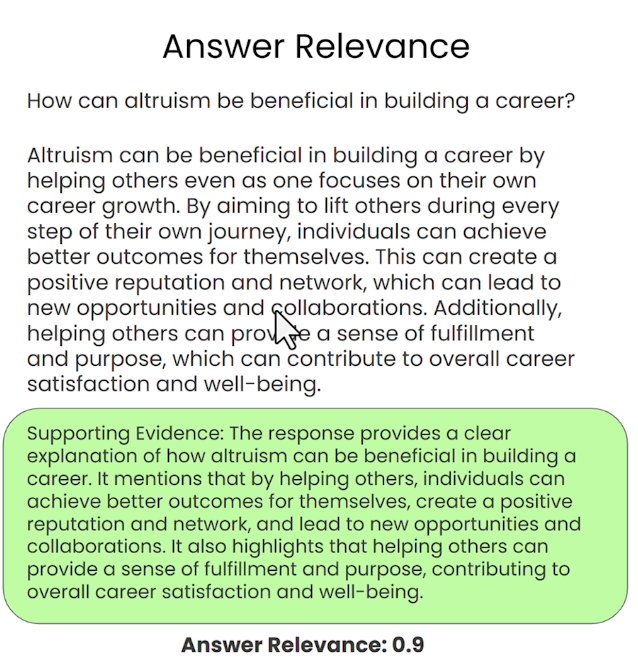

In [13]:
from trulens_eval import Feedback

f_qa_relevance = Feedback(
    provider.relevance_with_cot_reasons,
    name="Answer Relevance"
).on_input_output()

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .


#### 2. Context Relevance

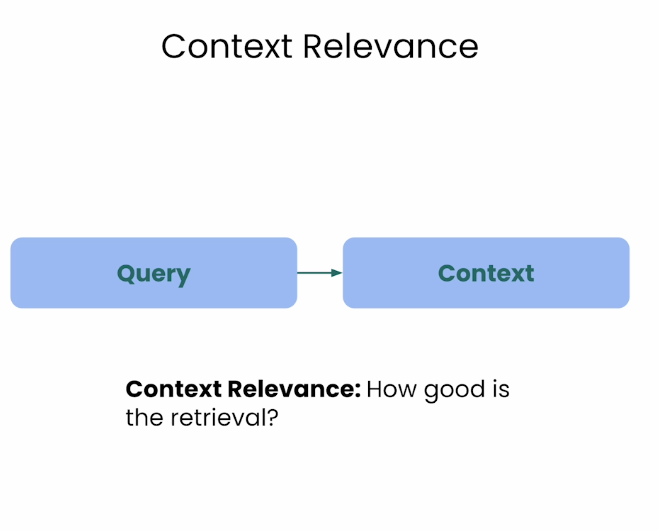

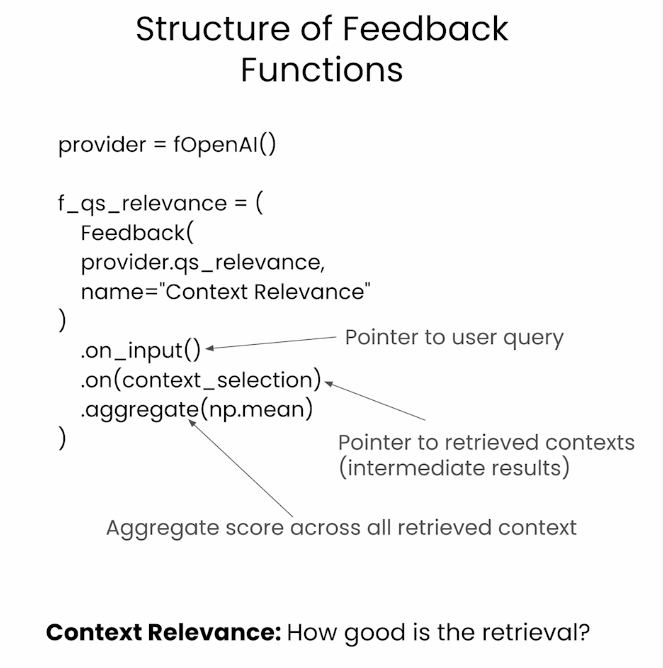

In [14]:
from trulens_eval import TruLlama

context_selection = TruLlama.select_source_nodes().node.text

In [15]:
import numpy as np

f_qs_relevance = (
    Feedback(provider.qs_relevance,
             name = "Context Relevance")
    .on_input()
    .on(context_selection)
    .aggregate(np.mean)
)

✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input statement will be set to __record__.app.query.rets.source_nodes[:].node.text .


In [ ]:
# If you need a justification for the result

f_qs_relevance_cot = (
    Feedback(provider.qs_relevance,
             name="Context Relevance")
    .on_input()
    .on(context_selection)
    .aggregate(np.mean)
)

#### 3. Groundedness

In [16]:
from trulens_eval.feedback import Groundedness

grounded = Groundedness(groundedness_provider = provider)

In [17]:
f_grounedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons,
            name = "Groundedness"
            )
    .on(context_selection) #RAG retriever
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


## Evaluation of the RAG application

In [18]:
from trulens_eval import TruLlama
from trulens_eval import FeedbackMode

tru_recorder = TruLlama(
    sentence_window_engine,
    app_id = "App_1",
    feedbacks = [
        f_qa_relevance,
        f_qs_relevance,
        f_grounedness
    ]
)

In [19]:
eval_questions = []
with open('./data/eval_questions.txt','r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

In [21]:
eval_questions.append("How can I be successful in AI?")

In [22]:
eval_questions

['What are the keys to building a career in AI?',
 'How can teamwork contribute to success in AI?',
 'What is the importance of networking in AI?',
 'What are some good habits to develop for a successful career?',
 'How can altruism be beneficial in building a career?',
 'What is imposter syndrome and how does it relate to AI?',
 'Who are some accomplished individuals who have experienced imposter syndrome?',
 'What is the first step to becoming good at AI?',
 'What are some common challenges in AI?',
 'Is it normal to find parts of AI challenging?',
 'How can I be successful in AI?']

In [23]:
for question in eval_questions:
    with tru_recorder as recording:
        sentence_window_engine.query(question)

In [25]:
records, feedback =  tru.get_records_and_feedback(app_ids = [])
records.head()

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
0,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_921acfb9f2dcec59ae6e9562793cd0e6,"""What are the keys to building a career in AI?""","""The keys to building a career in AI are learn...",-,"{""record_id"": ""record_hash_921acfb9f2dcec59ae6...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2023-12-03T15:21:08.107418"", ""...",2023-12-03T15:21:12.089757,1.0,0.35,1.000,[{'args': {'prompt': 'What are the keys to bui...,[{'args': {'question': 'What are the keys to b...,[{'args': {'source': 'Chapter 7: A Simple Fram...,3,514,0.000788
1,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_4d9ea310c5a53959b504015f109b8def,"""How can teamwork contribute to success in AI?""","""Teamwork can contribute to success in AI by a...",-,"{""record_id"": ""record_hash_4d9ea310c5a53959b50...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2023-12-03T15:21:13.054688"", ""...",2023-12-03T15:21:17.652782,1.0,0.40,0.950,[{'args': {'prompt': 'How can teamwork contrib...,[{'args': {'question': 'How can teamwork contr...,[{'args': {'source': 'To get a project starte...,4,662,0.001045
2,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_7c3644dea26bd91575fb952d94378866,"""What is the importance of networking in AI?""","""Networking is important in AI because it allo...",-,"{""record_id"": ""record_hash_7c3644dea26bd91575f...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2023-12-03T15:21:18.168335"", ""...",2023-12-03T15:21:22.209816,1.0,0.20,0.325,[{'args': {'prompt': 'What is the importance o...,[{'args': {'question': 'What is the importance...,[{'args': {'source': 'What is the hiring proce...,4,532,0.000847
3,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_34346aec6aff6266c5a8b9ac3e47cd3c,"""What are some good habits to develop for a su...","""Developing good habits in eating, exercise, s...",-,"{""record_id"": ""record_hash_34346aec6aff6266c5a...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2023-12-03T15:21:22.740148"", ""...",2023-12-03T15:21:25.795232,1.0,0.30,1.000,[{'args': {'prompt': 'What are some good habit...,[{'args': {'question': 'What are some good hab...,"[{'args': {'source': '(For example, many arti...",3,447,0.000696
4,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_06f6c21d7660bc8480002596515bb09d,"""How can altruism be beneficial in building a ...","""Altruism can be beneficial in building a care...",-,"{""record_id"": ""record_hash_06f6c21d7660bc84800...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2023-12-03T15:21:26.291665"", ""...",2023-12-03T15:21:29.534163,1.0,0.35,0.400,[{'args': {'prompt': 'How can altruism be bene...,[{'args': {'question': 'How can altruism be be...,[{'args': {'source': 'Many successful people d...,3,573,0.000916


In [26]:
import pandas as pd

pd.set_option("display.max_colwidth", None)
records[["input", "output"] + feedback]

,input,output,Answer Relevance,Context Relevance,Groundedness
0,"""What are the keys to building a career in AI?""","""The keys to building a career in AI are learning foundational technical skills, working on projects, and finding a job, all of which is supported by being part of a community.""",1.0,0.35,1.000
1,"""How can teamwork contribute to success in AI?""","""Teamwork can contribute to success in AI by allowing individuals to leverage the expertise and insights of their colleagues. When working on larger AI projects that require collaboration, the ability to lead and work effectively as a team becomes crucial. By working together, team members can share their deep technical insights, make informed decisions about technical architecture or data collection, and ultimately improve the project. Additionally, being surrounded by colleagues who are dedicated, hardworking, and continuously learning can inspire individuals to do the same, leading to greater success in AI endeavors.""",1.0,0.40,0.950
2,"""What is the importance of networking in AI?""","""Networking is important in AI because it allows individuals to connect with others who have experience and knowledge in the field. By reaching out to people in their network, such as friends or alumni, individuals can receive guidance and support as they navigate their AI career. Additionally, attending meetups and engaging in informational interviews can help individuals expand their network and gain insights from professionals in AI. This networking can be valuable in terms of learning about job opportunities, staying updated on industry trends, and receiving mentorship.""",1.0,0.20,0.325
3,"""What are some good habits to develop for a successful career?""","""Developing good habits in eating, exercise, sleep, personal relationships, work, learning, and self-care can be beneficial for a successful career. These habits can help individuals move forward while staying healthy and contribute to their overall success in their professional lives.""",1.0,0.30,1.000
4,"""How can altruism be beneficial in building a career?""","""Altruism can be beneficial in building a career by helping others while also advancing one's own career. By aiming to lift others during every step of their own journey, individuals can achieve better outcomes for themselves. This can be done by offering support, guidance, and assistance to others in their professional endeavors. By helping others succeed, individuals can build strong relationships, expand their network, and gain a positive reputation in their field. This can ultimately lead to new opportunities, collaborations, and personal growth, all of which can contribute to building an exciting and thriving career.""",1.0,0.35,0.400
5,"""What is imposter syndrome and how does it relate to AI?""","""Imposter syndrome is a psychological phenomenon where individuals doubt their abilities and fear being exposed as frauds, despite evidence of their success. In the context of AI, newcomers to the field sometimes experience imposter syndrome, questioning whether they truly belong in the AI community and if they are capable of contributing. However, it is important to address and overcome imposter syndrome so that it does not discourage individuals from pursuing growth and success in AI.""",0.9,0.30,1.000
6,"""Who are some accomplished individuals who have experienced imposter syndrome?""","""Sheryl Sandberg, Michelle Obama, Tom Hanks, and Mike Cannon-Brookes are some accomplished individuals who have experienced imposter syndrome.""",1.0,0.50,1.000
7,"""What is the first step to becoming good at AI?""","""The first step to becoming good at AI is to learn foundational technical skills.""",1.0,0.40,1.000
8,"""What are some common challenges in AI?""","""Some common challenges in AI include keeping up-to-date with evolving technologies, finding suitable projects and estimating timelines and return on investment, managing the highly iterative nature of AI projects

In [27]:
tru.get_leaderboard(app_ids=[])

,Answer Relevance,Context Relevance,Groundedness,latency,total_cost
app_id,,,,,
App_1,0.990909,0.390909,0.847727,3.0,0.000883


In [28]:
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


FileNotFoundError: [WinError 2] The system cannot find the file specified